In [59]:
from neo4j import GraphDatabase
import pandas as pd

# Neo4j Connection Details
NEO4J_URI = "bolt://localhost:7687"
USERNAME = "neo4j"
PASSWORD = "neo4j"

# Connect to Neo4j
driver = GraphDatabase.driver(NEO4J_URI, auth=(USERNAME, PASSWORD))

# Function to Run Queries
def run_query(query):
    with driver.session() as session:
        result = session.run(query)
        return [record for record in result]

# Query for Disease-Gene Relationships
query = """
MATCH (d:Disease)-[r]->(g:Gene)
WHERE type(r) IN ['ASSOCIATES_DaG', 'UPREGULATES_DuG', 'DOWNREGULATES_DdG']
RETURN d.name AS Disease, g.name AS Gene, type(r) AS Relationship
LIMIT 10000
"""
data = run_query(query)

# Convert to Pandas DataFrame
df = pd.DataFrame(data, columns=["Disease", "Gene", "Relationship"])
print(df.head())

# Close Neo4j connection
driver.close()


            Disease     Gene    Relationship
0  bile duct cancer    ERBB2  ASSOCIATES_DaG
1  bile duct cancer  PPFIBP2  ASSOCIATES_DaG
2  bile duct cancer    PTGS2  ASSOCIATES_DaG
3  bile duct cancer    SOX17  ASSOCIATES_DaG
4  bile duct cancer    PTPRE  ASSOCIATES_DaG


In [60]:
import networkx as nx

# Build an undirected graph
G = nx.Graph()
for _, row in df.iterrows():
    G.add_edge(row['Disease'], row['Gene'], relationship=row['Relationship'])

print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

# Compute PageRank and assign as node feature
pagerank_scores = nx.pagerank(G)
nx.set_node_attributes(G, pagerank_scores, "pagerank")

# Prepare feature matrix
features = []
node_idx_mapping = {}
for idx, node in enumerate(G.nodes()):
    node_idx_mapping[node] = idx
    features.append([pagerank_scores[node]])

import torch
import numpy as np

x = torch.tensor(features, dtype=torch.float)
print(f"Feature tensor shape: {x.shape}")


Graph has 6416 nodes and 9895 edges.
Feature tensor shape: torch.Size([6416, 1])


In [61]:
from torch_geometric.utils import from_networkx
from torch_geometric.data import Data

# Remap nodes to 0...n-1
G = nx.relabel_nodes(G, node_idx_mapping)
data = from_networkx(G)
data.x = x

print(data)


Data(edge_index=[2, 19790], pagerank=[6416], relationship=[19790], num_nodes=6416, x=[6416, 1])


In [62]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

class GCNLinkPredictor(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.link_predictor = torch.nn.Linear(2 * hidden_channels, 1)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

    def decode(self, z, edge_index):
        src, dst = edge_index
        out = torch.cat([z[src], z[dst]], dim=1)
        return self.link_predictor(out)

model = GCNLinkPredictor(in_channels=1, hidden_channels=32)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [63]:
from torch_geometric.utils import negative_sampling

edge_index = data.edge_index

# Create negative edges
neg_edge_index = negative_sampling(
    edge_index=edge_index,
    num_nodes=data.num_nodes,
    num_neg_samples=edge_index.size(1)
)

print(f"Positive edges: {edge_index.shape[1]}")
print(f"Negative edges: {neg_edge_index.shape[1]}")


Positive edges: 19790
Negative edges: 19790


In [64]:
def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x, data.edge_index)

    # Positive edges
    pos_out = model.decode(z, edge_index)
    pos_label = torch.ones(pos_out.size(0), 1)

    # Negative edges
    neg_out = model.decode(z, neg_edge_index)
    neg_label = torch.zeros(neg_out.size(0), 1)

    # Combine
    out = torch.cat([pos_out, neg_out], dim=0)
    label = torch.cat([pos_label, neg_label], dim=0)

    loss = F.binary_cross_entropy_with_logits(out, label)
    loss.backward()
    optimizer.step()
    return loss

for epoch in range(1, 51):
    loss = train()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}')


Epoch 10, Loss: 0.3420
Epoch 20, Loss: 0.1625
Epoch 30, Loss: 0.0901
Epoch 40, Loss: 0.0693
Epoch 50, Loss: 0.0678


In [65]:
from sklearn.metrics import roc_auc_score

@torch.no_grad()
def test():
    model.eval()
    z = model.encode(data.x, data.edge_index)
    
    pos_out = model.decode(z, edge_index).sigmoid()
    neg_out = model.decode(z, neg_edge_index).sigmoid()

    y_pred = torch.cat([pos_out, neg_out]).squeeze().cpu().numpy()
    y_true = np.concatenate([np.ones(pos_out.size(0)), np.zeros(neg_out.size(0))])

    auc = roc_auc_score(y_true, y_pred)
    print(f'AUC-ROC Score: {auc:.4f}')

test()

AUC-ROC Score: 0.9979


In [66]:
@torch.no_grad()
def test():
    model.eval()
    z = model.encode(data.x, data.edge_index)
    
    pos_out = model.decode(z, edge_index).sigmoid()
    neg_out = model.decode(z, neg_edge_index).sigmoid()

    y_pred = torch.cat([pos_out, neg_out]).squeeze().cpu().numpy()
    y_true = np.concatenate([np.ones(pos_out.size(0)), np.zeros(neg_out.size(0))])

    auc_score = roc_auc_score(y_true, y_pred)
    print(f'AUC-ROC Score: {auc_score:.4f}')
    
    return y_true, y_pred  # <-- ADD THIS LINE


AUC-ROC Score: 0.9979


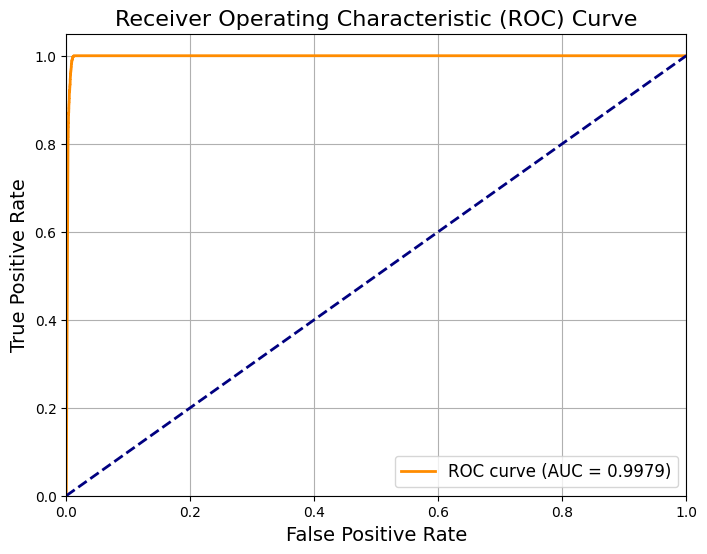

In [67]:
# Get outputs
y_true, y_pred = test()

# Now you can compute ROC curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute FPR, TPR
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True)
plt.show()


In [68]:
from torch_geometric.utils import negative_sampling

# Generate more negative samples (new disease-gene candidates)
new_neg_edge_index = negative_sampling(
    edge_index=edge_index,
    num_nodes=data.num_nodes,
    num_neg_samples=10000  # More negatives for broader prediction
)


In [69]:
model.eval()

# Encode node features into embeddings
z = model.encode(data.x, data.edge_index)

# Predict scores for new candidate edges
new_link_scores = model.decode(z, new_neg_edge_index).sigmoid()


In [70]:
# Sort scores in descending order
topk = 20  # How many top predictions you want
top_scores, top_indices = torch.topk(new_link_scores.squeeze(), topk)

print("Top Predicted New Disease-Gene Pairs:\n")
for i in range(topk):
    src = new_neg_edge_index[0, top_indices[i]].item()
    dst = new_neg_edge_index[1, top_indices[i]].item()
    print(f"Pair {i+1}: Node {src} ↔ Node {dst} with predicted score {top_scores[i].item():.4f}")


Top Predicted New Disease-Gene Pairs:

Pair 1: Node 1493 ↔ Node 5714 with predicted score 1.0000
Pair 2: Node 2826 ↔ Node 1861 with predicted score 1.0000
Pair 3: Node 5714 ↔ Node 3037 with predicted score 1.0000
Pair 4: Node 6380 ↔ Node 43 with predicted score 1.0000
Pair 5: Node 4378 ↔ Node 6329 with predicted score 1.0000
Pair 6: Node 2523 ↔ Node 854 with predicted score 1.0000
Pair 7: Node 651 ↔ Node 3558 with predicted score 1.0000
Pair 8: Node 534 ↔ Node 4378 with predicted score 1.0000
Pair 9: Node 2995 ↔ Node 6136 with predicted score 1.0000
Pair 10: Node 43 ↔ Node 4209 with predicted score 1.0000
Pair 11: Node 4571 ↔ Node 5714 with predicted score 1.0000
Pair 12: Node 1837 ↔ Node 3397 with predicted score 1.0000
Pair 13: Node 5254 ↔ Node 2475 with predicted score 1.0000
Pair 14: Node 1861 ↔ Node 1242 with predicted score 1.0000
Pair 15: Node 4743 ↔ Node 3764 with predicted score 1.0000
Pair 16: Node 5714 ↔ Node 2859 with predicted score 1.0000
Pair 17: Node 1057 ↔ Node 5254 wi

In [71]:
reverse_mapping = {v: k for k, v in node_idx_mapping.items()}

disease_gene_pairs = []
for i in range(topk):
    src = new_neg_edge_index[0, top_indices[i]].item()
    dst = new_neg_edge_index[1, top_indices[i]].item()
    disease_gene_pairs.append((reverse_mapping[src], reverse_mapping[dst], top_scores[i].item()))


In [72]:
print("Top Predicted New Disease-Gene Pairs (with real node IDs):\n")
for i, (disease, gene, score) in enumerate(disease_gene_pairs, 1):
    print(f"{i}. Disease: {disease} ↔ Gene: {gene} | Predicted Score: {score:.4f}")

Top Predicted New Disease-Gene Pairs (with real node IDs):

1. Disease: RNF13 ↔ Gene: IgA glomerulonephritis | Predicted Score: 1.0000
2. Disease: YIPF3 ↔ Gene: nicotine dependence | Predicted Score: 1.0000
3. Disease: IgA glomerulonephritis ↔ Gene: OCM | Predicted Score: 1.0000
4. Disease: CYSLTR2 ↔ Gene: Crohn's disease | Predicted Score: 1.0000
5. Disease: breast cancer ↔ Gene: TYR | Predicted Score: 1.0000
6. Disease: idiopathic pulmonary fibrosis ↔ Gene: ACADL | Predicted Score: 1.0000
7. Disease: pancreatic cancer ↔ Gene: TPD52 | Predicted Score: 1.0000
8. Disease: MAGED1 ↔ Gene: breast cancer | Predicted Score: 1.0000
9. Disease: hypertension ↔ Gene: FAM105A | Predicted Score: 1.0000
10. Disease: Crohn's disease ↔ Gene: JUN | Predicted Score: 1.0000
11. Disease: C16orf58 ↔ Gene: IgA glomerulonephritis | Predicted Score: 1.0000
12. Disease: TCF7L2 ↔ Gene: prostate cancer | Predicted Score: 1.0000
13. Disease: alopecia areata ↔ Gene: MBP | Predicted Score: 1.0000
14. Disease: nico

In [73]:
# Step 1: Fetch all existing disease-gene relationships at once
def fetch_existing_links():
    query = """
    MATCH (d:Disease)-[r]->(g:Gene)
    WHERE type(r) IN ['ASSOCIATES_DaG', 'UPREGULATES_DuG', 'DOWNREGULATES_DdG']
    RETURN d.name AS Disease, g.name AS Gene
    """
    with driver.session() as session:
        result = session.run(query)
        existing_links = set()
        for record in result:
            existing_links.add( (record["Disease"], record["Gene"]) )
    return existing_links

# Step 2: Check top predicted pairs against this set
existing_links = fetch_existing_links()

for i, (disease, gene, score) in enumerate(disease_gene_pairs, 1):
    if (disease, gene) in existing_links:
        print(f"{i}. Link EXISTS: {disease} ↔ {gene} | Predicted Score: {score:.4f}")
    else:
        print(f"{i}. Link NOT FOUND: {disease} ↔ {gene} | Predicted Score: {score:.4f}")


C:\Users\banje\AppData\Local\Temp\ipykernel_29252\3810451219.py:8: DeprecationWarning: Using a driver after it has been closed is deprecated. Future versions of the driver will raise an error.
  with driver.session() as session:


1. Link NOT FOUND: RNF13 ↔ IgA glomerulonephritis | Predicted Score: 1.0000
2. Link NOT FOUND: YIPF3 ↔ nicotine dependence | Predicted Score: 1.0000
3. Link NOT FOUND: IgA glomerulonephritis ↔ OCM | Predicted Score: 1.0000
4. Link NOT FOUND: CYSLTR2 ↔ Crohn's disease | Predicted Score: 1.0000
5. Link NOT FOUND: breast cancer ↔ TYR | Predicted Score: 1.0000
6. Link NOT FOUND: idiopathic pulmonary fibrosis ↔ ACADL | Predicted Score: 1.0000
7. Link NOT FOUND: pancreatic cancer ↔ TPD52 | Predicted Score: 1.0000
8. Link NOT FOUND: MAGED1 ↔ breast cancer | Predicted Score: 1.0000
9. Link NOT FOUND: hypertension ↔ FAM105A | Predicted Score: 1.0000
10. Link NOT FOUND: Crohn's disease ↔ JUN | Predicted Score: 1.0000
11. Link NOT FOUND: C16orf58 ↔ IgA glomerulonephritis | Predicted Score: 1.0000
12. Link NOT FOUND: TCF7L2 ↔ prostate cancer | Predicted Score: 1.0000
13. Link NOT FOUND: alopecia areata ↔ MBP | Predicted Score: 1.0000
14. Link NOT FOUND: nicotine dependence ↔ LMAN2L | Predicted Sco